In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# some function
def f(x):
    return 3*x**2 - 4*x + 5

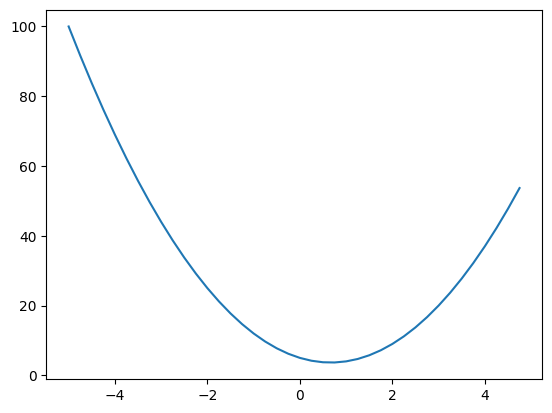

In [4]:
# plot the function
xs = np.arange(-5, 5, 0.25) # from -5 to 5 every 0.25
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# derivative
h = 0.0000001
x = 2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [6]:
# more complex function (more variables)
a = 2.0
b = -3.0
c = 10
d = a * b + c
print(d)

4.0


In [7]:
# derivatives
h = 0.001

a = 2.0
b = -3.0
c = 10

d1 = a * b + c
da = (a + h) * b + c
print('a', (da - d1) / h)

db = a * (b + h) + c
print('b', (db - d1) / h)

dc = a * b + (c + h)
print('c', (dc - d1) / h)

a -3.0000000000001137
b 1.9999999999997797
c 0.9999999999994458


In [8]:
# value class
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other    

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        reverse_topological_order = []
        visited = set()

        def reverse_topological_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    reverse_topological_sort(child)
                reverse_topological_order.append(node)
        
        reverse_topological_sort(self)
        print(reverse_topological_order)

        self.grad = 1.0
        for node in reversed(reverse_topological_order):
            node._backward()

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(2.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = "L"
L

Value(data=8.0)

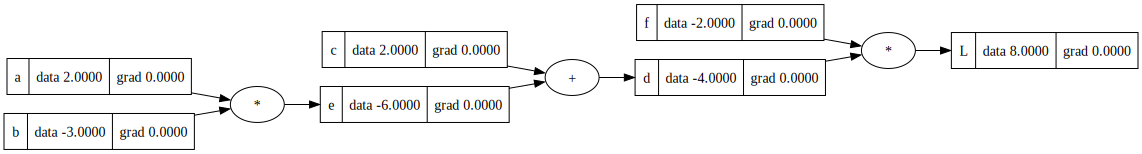

In [10]:
# makes graphs
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape = "record")
        if node._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + node._op, label = node._op)
            # and connect this node to it
            dot.edge(uid + node._op, uid)
    
    for node1, node2 in edges:
        # connect node1 to the op node of node2
        dot.edge(str(id(node1)), str(id(node2)) + node2._op)
    
    return dot

draw_dot(L)

[Value(data=2.0), Value(data=1.0), Value(data=3.0)]


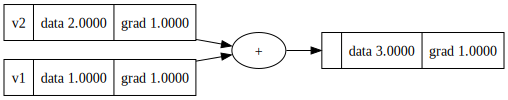

In [12]:
v1 = Value(1.0, label="v1")
v2 = Value(2.0, label="v2")
v2 = v2 + v1
v2.backward()
draw_dot(v2)

[Value(data=3.0), Value(data=2.0), Value(data=6.0), Value(data=36.0)]


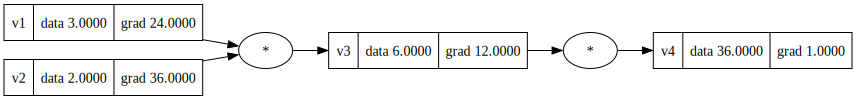

In [78]:
v1 = Value(3.0, label="v1")
v2 = Value(2.0, label="v2")
v3 = v1 * v2
v4 = v3 * v3
v3.label='v3'
v4.label='v4'
v4.backward()
draw_dot(v4)

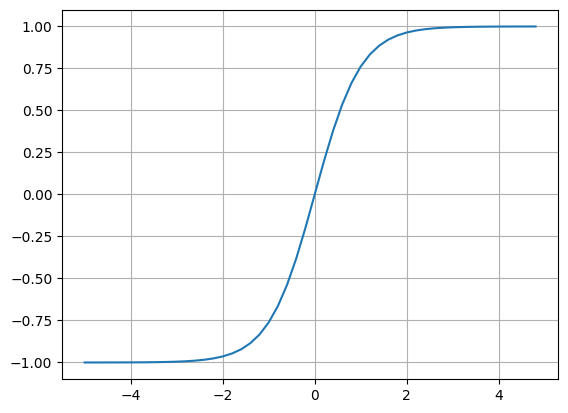

In [64]:
# tanh function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

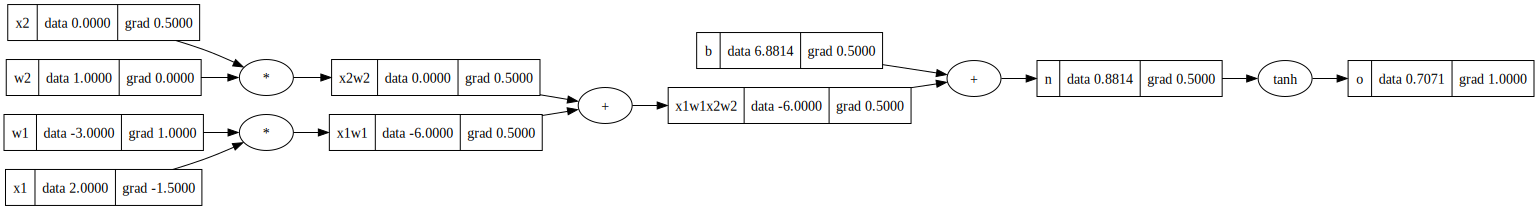

In [65]:
# neuron inputs
input1 = Value(2.0, label='x1')
input2 = Value(0.0, label='x2')
# neuron weights
weight1 = Value(-3.0, label='w1')
weight2 = Value(1.0, label='w2')
# neuron bias
bias = Value(6.88137, label='b')

input1weight1 = input1 * weight1; input1weight1.label='x1w1'
input2weight2 = input2 * weight2; input2weight2.label='x2w2'
input1weight1input2weight2 = input1weight1 + input2weight2; input1weight1input2weight2.label='x1w1x2w2'
neuron = input1weight1input2weight2 + bias; neuron.label='n'
output = neuron.tanh(); output.label = 'o'

output.backward()
draw_dot(output)

In [66]:
import random


# Neuron
class Neuron:

    def __init__(self, number_of_inputs):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, inputs):
        actual = sum((wi * xi for wi, xi in zip(self.weights, inputs)), self.bias)
        output = actual.tanh()
        return output

    def parameters(self):
        return self.weights + [self.bias]
    

# Layer of neurons
class Layer:

    def __init__(self, number_of_inputs, number_of_neurons):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_neurons)]

    def __call__(self, inputs):
        outputs = [neuron(inputs) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]


# Multi Layer Perceptron
class MLP:

    def __init__(self, number_of_inputs, neurons_per_layer):
        size = [number_of_inputs] + neurons_per_layer
        print(size)
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(neurons_per_layer))]

    def __call__(self, inputs):
        for layer in self.layers:
            inputs= layer(inputs)
        return inputs
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

[3, 4, 4, 1]


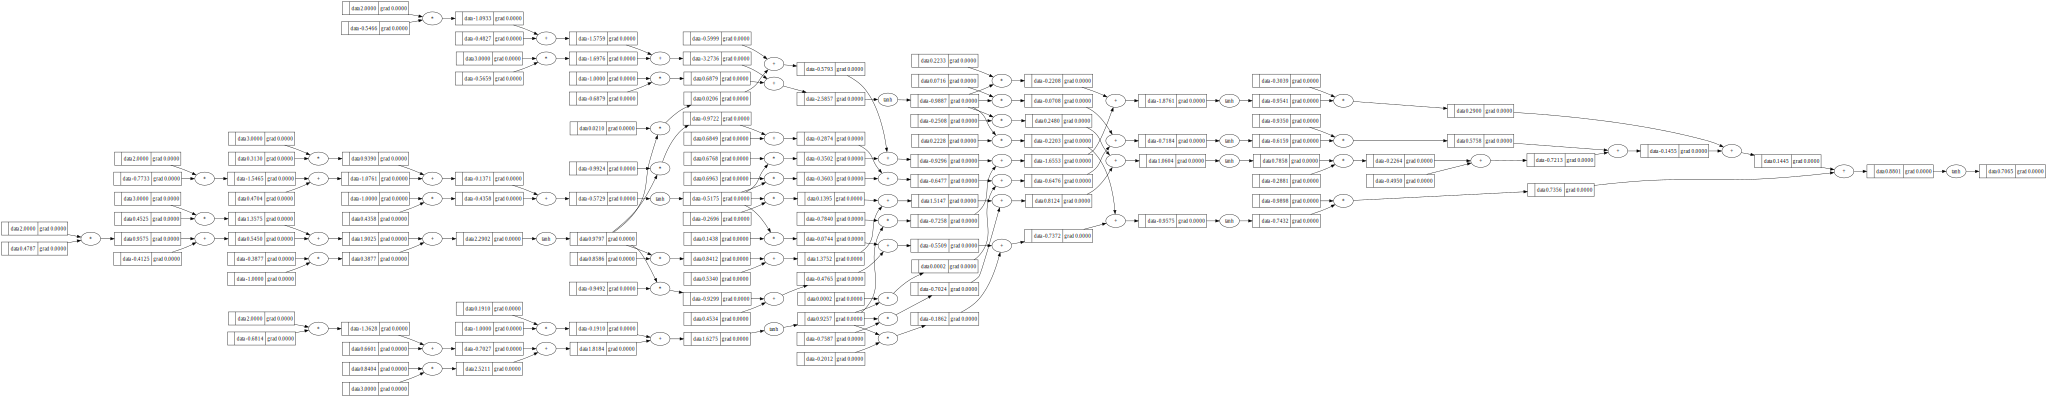

In [67]:
inputs = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(inputs)
draw_dot(n(inputs))

In [68]:
n.parameters()

[Value(data=0.4787423864831586),
 Value(data=0.4525026683705493),
 Value(data=-0.3877028451336775),
 Value(data=-0.41250993930694824),
 Value(data=-0.7732659917574765),
 Value(data=0.31301286362311154),
 Value(data=0.4358117937757502),
 Value(data=0.47039273438134455),
 Value(data=-0.6814153727819692),
 Value(data=0.8403799266197189),
 Value(data=0.19095346897700405),
 Value(data=0.6601099945048827),
 Value(data=-0.5466336033598782),
 Value(data=-0.5658814078880905),
 Value(data=-0.6878717640447163),
 Value(data=-0.48266704525890214),
 Value(data=0.8586494625400811),
 Value(data=-0.2696256247180766),
 Value(data=-0.7587313539323779),
 Value(data=-0.250826917413582),
 Value(data=0.5339794066274415),
 Value(data=-0.9923786524725673),
 Value(data=0.6963247447805114),
 Value(data=0.00017082455451422618),
 Value(data=0.07161457361263968),
 Value(data=0.6848688858009355),
 Value(data=0.021005804930647187),
 Value(data=0.6768122126411413),
 Value(data=-0.7840091160393097),
 Value(data=0.22330

In [69]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7064583580432588),
 Value(data=-0.18279113092194157),
 Value(data=-0.8468456113828983),
 Value(data=0.3639547509509638)]

In [70]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.1820068568530278)

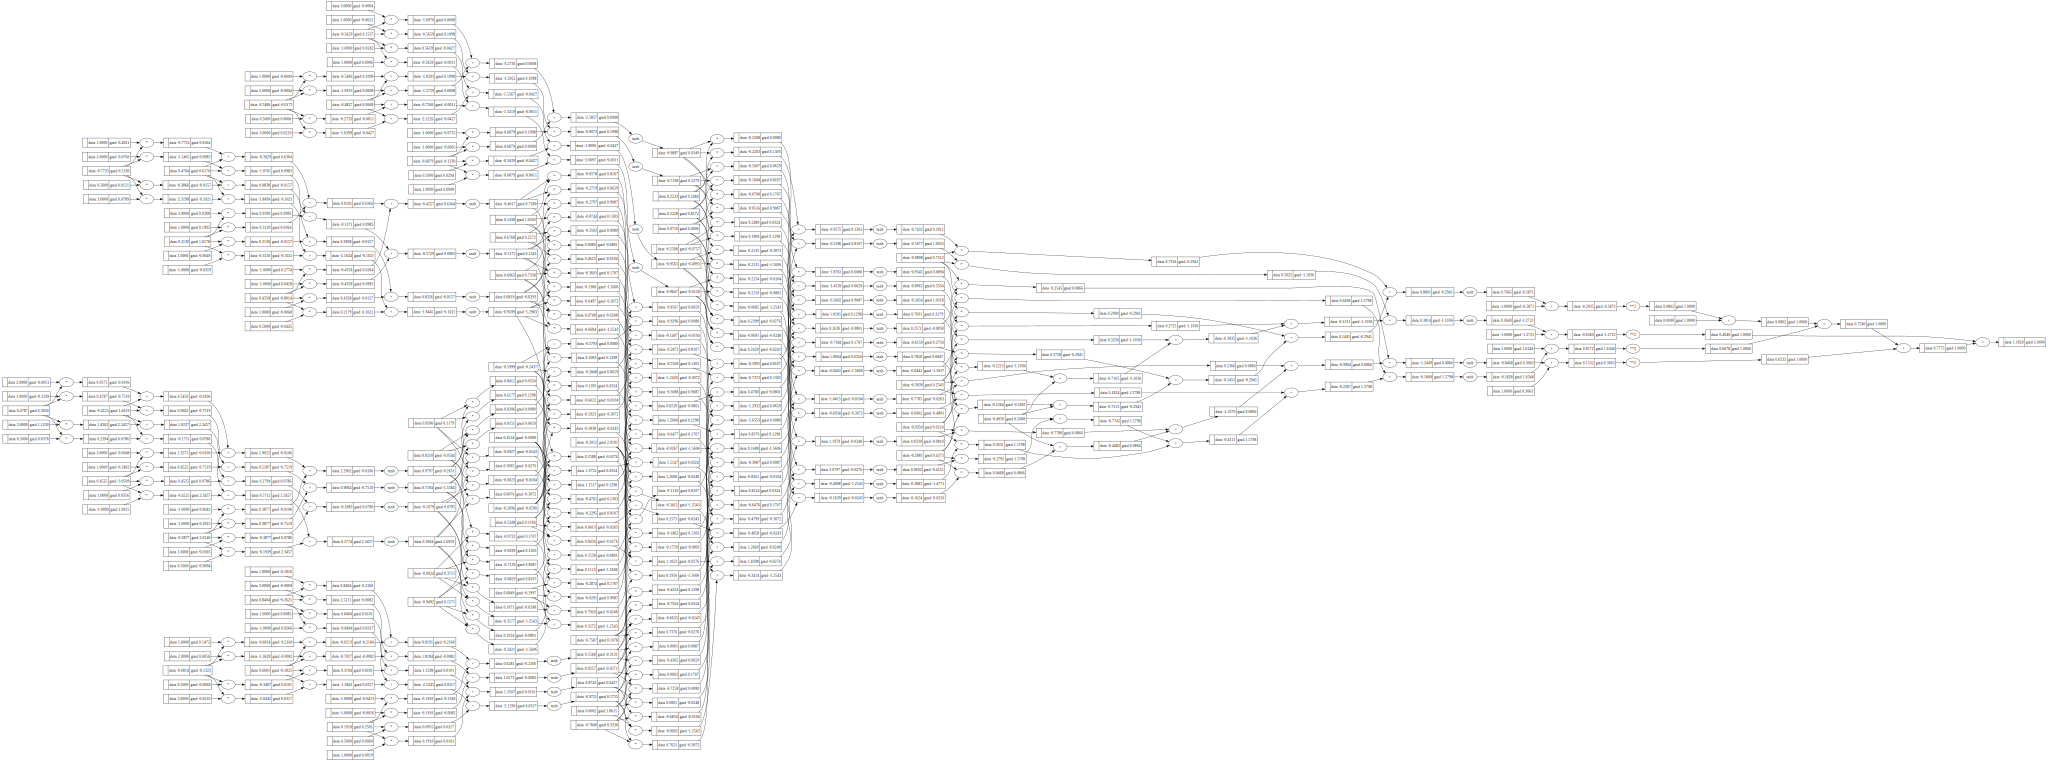

In [71]:
loss.backward()
draw_dot(loss)

In [72]:
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 1.1820068568530278
1 0.5972820634747908
2 0.1498970833426887
3 0.030542066378795904
4 0.02657463242386876
5 0.023777907332727416
6 0.021631319385054144
7 0.019899849276190852
8 0.01845776775921739
9 0.017229681861843288
10 0.01616655054281976
11 0.015234501846587154
12 0.014409055890673265
13 0.013671890183159553
14 0.01300890702207493
15 0.012409015870667213
16 0.01186333176570424
17 0.011364627935348252
18 0.010906950336098186
19 0.01048533905419477
20 0.010095622423542217
21 0.009734261947183565
22 0.009398233535764945
23 0.009084935232161797
24 0.00879211459519309
25 0.008517810903489072
26 0.008260308686901818
27 0.008018100023404851
28 0.0077898536945447214
29 0.007574389761421565
30 0.007370658463878364
31 0.007177722596509724
32 0.006994742702218058
33 0.006820964565158983
34 0.006655708592449585
35 0.006498360756734781
36 0.006348364835908904
37 0.006205215736520598
38 0.0060684537269917955
39 0.005937659438220784
40 0.00581244951426626
41 0.00569247281601325
42 0.0055774070

In [54]:
ypred

[Value(data=0.982429912840683),
 Value(data=-0.9708780482266517),
 Value(data=-0.9740101140401288),
 Value(data=0.9724232587959507)]